

# EEG analysis - Event-Related Potentials (ERPs)

This tutorial shows how to perform standard ERP analyses in MNE-Python. Most of
the material here is covered in other tutorials too, but for convenience the
functions and methods most useful for ERP analyses are collected here, with
links to other tutorials where more detailed information is given.

As usual we'll start by importing the modules we need and loading some example
data. Instead of parsing the events from the raw data's :term:`stim channel`
(like we do in `this tutorial <tut-events-vs-annotations>`), we'll load
the events from an external events file. Finally, to speed up computations
we'll crop the raw data from ~4.5 minutes down to 90 seconds.


In [ ]:
# Authors: The MNE-Python contributors.
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mne

root = mne.datasets.sample.data_path() / "MEG" / "sample"
raw_file = root / "sample_audvis_filt-0-40_raw.fif"
raw = mne.io.read_raw_fif(raw_file, preload=False)

events_file = root / "sample_audvis_filt-0-40_raw-eve.fif"
events = mne.read_events(events_file)

raw.crop(tmax=90)  # in seconds (happens in-place)
# discard events >90 seconds (not strictly necessary, but avoids some warnings)
events = events[events[:, 0] <= raw.last_samp]

Opening raw data file C:\Users\kyungho\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


The file that we loaded has already been partially processed: 3D sensor
locations have been saved as part of the ``.fif`` file, the data have been
low-pass filtered at 40 Hz, and a common average reference is set for the
EEG channels, stored as a projector (see `section-avg-ref-proj` in the
`tut-set-eeg-ref` tutorial for more info about when you may want to do
this). We'll discuss how to do each of these below.

Since this is a combined EEG/MEG dataset, let's start by restricting the data
to just the EEG and EOG channels. This will cause the other projectors saved
in the file (which apply only to magnetometer channels) to be removed. By
looking at the measurement info we can see that we now have 59 EEG channels
and 1 EOG channel.



In [2]:
raw.pick(["eeg", "eog"]).load_data()
raw.info

Reading 0 ... 13514  =      0.000 ...    90.001 secs...


<Info | 14 non-empty values
 bads: 1 items (EEG 053)
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 61
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>

## Channel names and types

In practice it is quite common to have some channels labeled as EEG that are
actually EOG channels. :class:`~mne.io.Raw` objects have a
:meth:`~mne.io.Raw.set_channel_types` method that can be used to change a
channel that is mislabeled as ``eeg`` to ``eog``.

You can also rename channels using :meth:`~mne.io.Raw.rename_channels`.
Detailed examples of both of these methods can be found in the tutorial
`tut-raw-class`.

In our data set, all channel types are already correct. Therefore, we'll only
remove a space and a leading zero in the channel names and convert to
lowercase:



In [3]:
channel_renaming_dict = {name: name.replace(" 0", "").lower() for name in raw.ch_names}
_ = raw.rename_channels(channel_renaming_dict)  # happens in-place

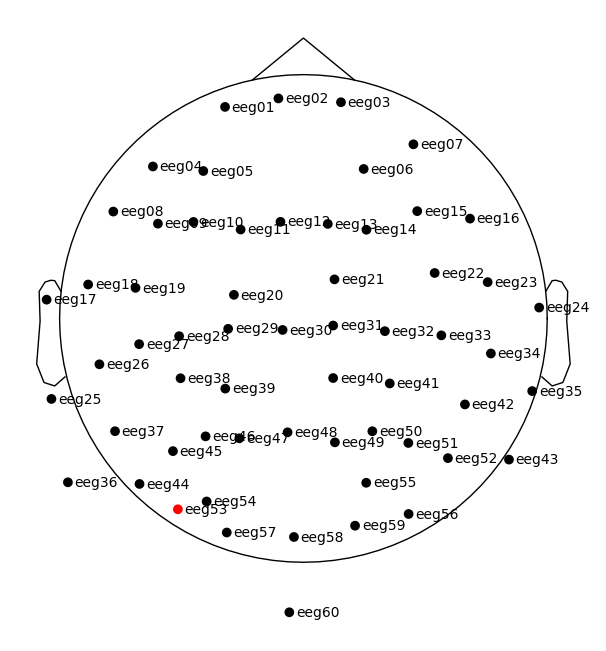

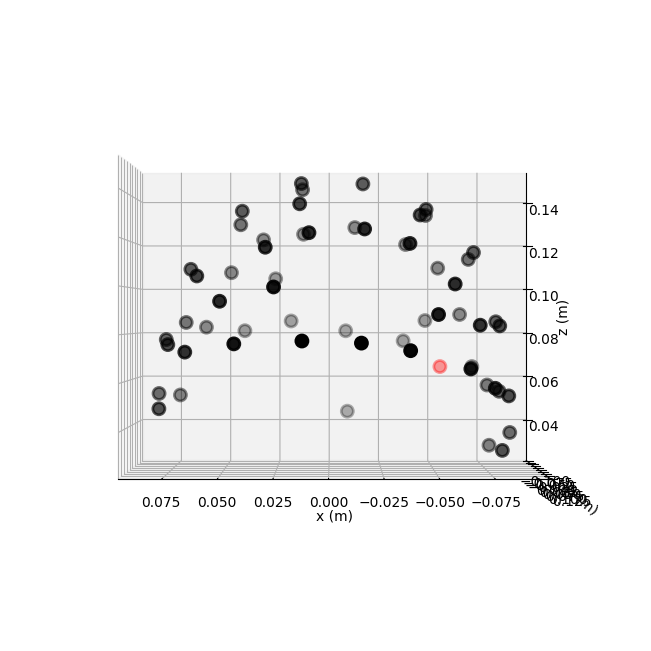

In [4]:
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors("3d")

If you're working with a standard montage like the [10–20](ten_twenty_)
system, you can add sensor locations to the data with
``raw.set_montage('standard_1020')`` (see `tut-sensor-locations` for
information on other standard montages included with MNE-Python).

If you have digitized realistic sensor locations, there are dedicated
functions for loading those digitization files into MNE-Python (see
`reading-dig-montages` for discussion and `dig-formats` for a list
of supported formats). Once loaded, the digitized sensor locations can be
added to the data by passing the loaded montage object to
:meth:`~mne.io.Raw.set_montage`.


## Setting the EEG reference

As mentioned, this data already has an EEG common average reference
added as a :term:`projector`. We can view the effect of this projector on the
raw data by plotting it with and without the projector applied:



Using matplotlib as 2D backend.


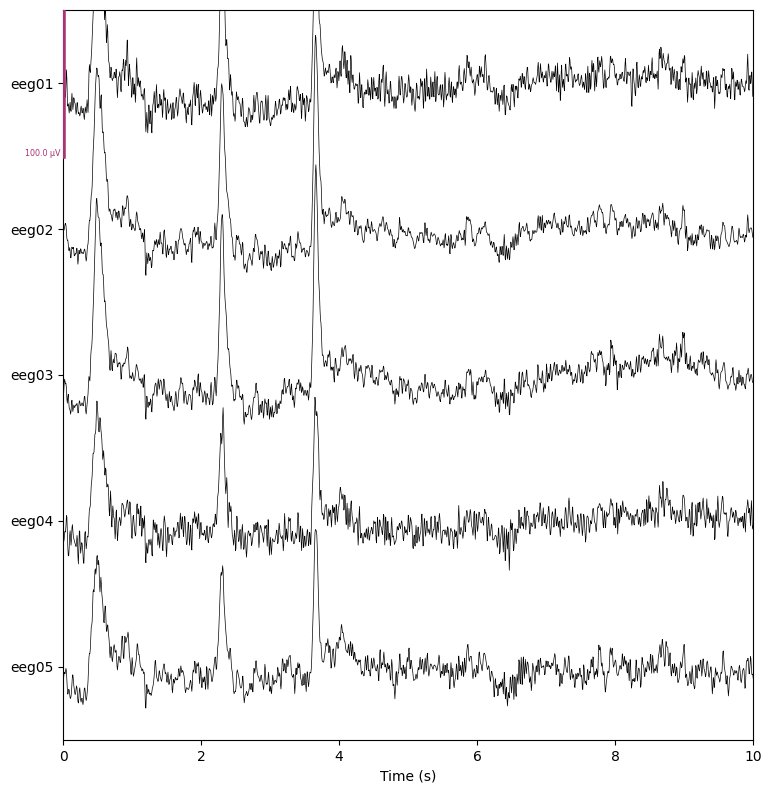

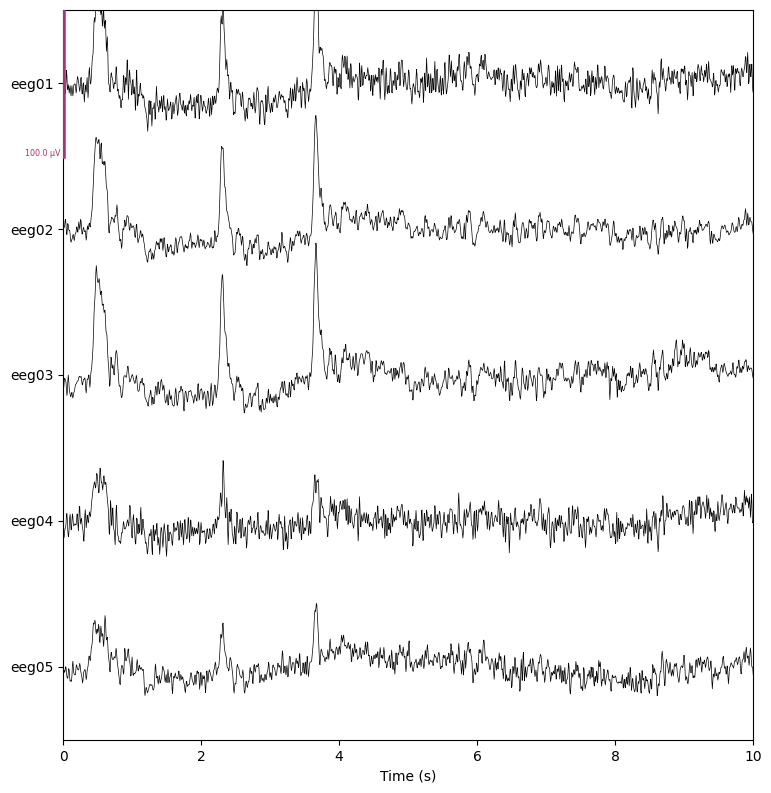

In [5]:
for proj in (False, True):
    with mne.viz.use_browser_backend("matplotlib"):
        fig = raw.plot(
            n_channels=5, proj=proj, scalings=dict(eeg=50e-6), show_scrollbars=False
        )
    fig.subplots_adjust(top=0.9)  # make room for title
    ref = "Average" if proj else "No"
    fig.suptitle(f"{ref} reference", size="xx-large", weight="bold")

The referencing scheme can be changed with the function
:func:`mne.set_eeg_reference` (which by default operates on a *copy* of the
data) or the :meth:`raw.set_eeg_reference() <mne.io.Raw.set_eeg_reference>`
method (which always modifies the data *in-place*). The tutorial
`tut-set-eeg-ref` shows several examples.


## Filtering

MNE-Python has extensive support for different ways of filtering data. For a
general discussion of filter characteristics and MNE-Python defaults, see
`disc-filtering`. For practical examples of how to apply filters to your
data, see `tut-filter-resample`. Here, we'll apply a simple high-pass
filter for illustration:



In [6]:
raw.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 4957 samples (33.013 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<Raw | sample_audvis_filt-0-40_raw.fif, 61 x 13515 (90.0 s), ~9.2 MiB, data loaded>

## Evoked responses: epoching and averaging

The general process for extracting evoked responses from continuous data is
to use the :class:`~mne.Epochs` constructor, and then average the resulting
epochs to create an :class:`~mne.Evoked` object. In MNE-Python, events are
represented as a :class:`NumPy array <numpy.ndarray>` containing event
latencies (in samples) and integer event codes. The event codes are stored in
the last column of the events array:



In [7]:
np.unique(events[:, -1])

array([ 1,  2,  3,  4,  5, 32])

The `tut-event-arrays` tutorial discusses event arrays in more detail.
Integer event codes are mapped to more descriptive text using a Python
:class:`dictionary <dict>` usually called ``event_id``. This mapping is
determined by your experiment (i.e., it reflects which event codes you chose
to represent different experimental events or conditions). The
`sample-dataset` data uses the following mapping:



In [8]:
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "face": 5,
    "buttonpress": 32,
}

Now we can proceed to epoch the continuous data. An interactive plot allows
us to click on epochs to mark them as "bad" and drop them from the
analysis (it is not interactive on this documentation website, but will be
when you run `epochs.plot() <mne.Epochs.plot>` in a Python console).



Not setting metadata
132 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 132 events and 151 original time points ...
1 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


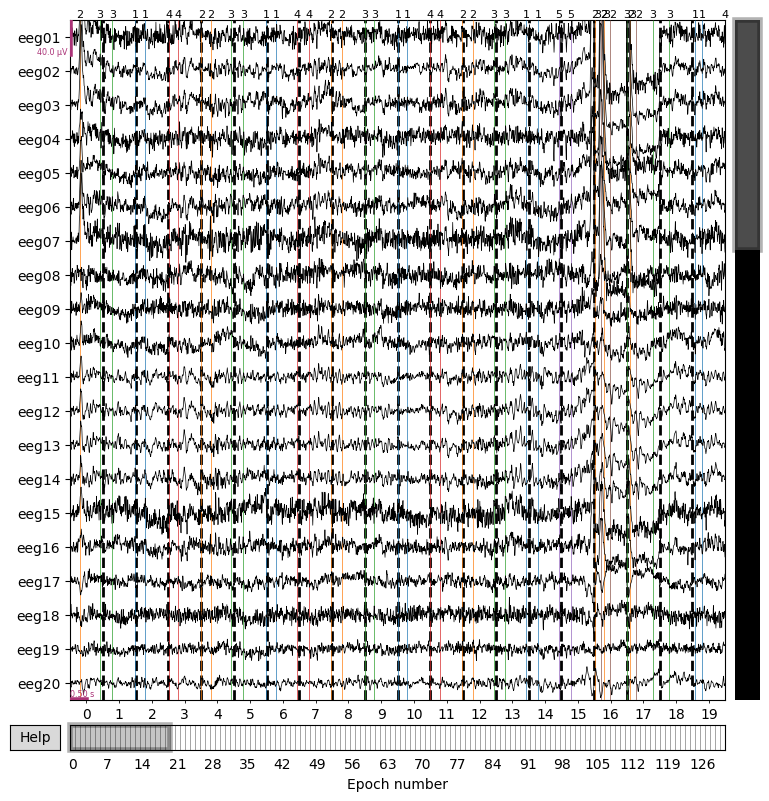

In [9]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=0.7, preload=True)
fig = epochs.plot(events=events)

It is also possible to automatically drop epochs (either when first creating
them or later on) by providing maximum peak-to-peak signal value thresholds
(passed to :class:`~mne.Epochs` as the ``reject`` parameter; see
`tut-reject-epochs-section` for details).  You can also do this after
the epochs are already created using :meth:`~mne.Epochs.drop_bad`:



In [10]:
reject_criteria = dict(eeg=100e-6, eog=200e-6)  # 100 µV, 200 µV
epochs.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['eeg03']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg03']
    Rejecting  epoch based on EEG : ['eeg25']
    Rejecting  epoch based on EEG : ['e

<Epochs | 114 events (all good), -0.3 – 0.699 s (baseline -0.3 – 0 s), ~10.9 MiB, data loaded,
 'auditory/left': 25
 'auditory/right': 27
 'visual/left': 28
 'visual/right': 25
 'face': 5
 'buttonpress': 4>

Next, we generate a barplot of which channels contributed most to epochs
getting rejected. If one channel is responsible for many epoch rejections,
it may be worthwhile to mark that channel as "bad" in the
:class:`~mne.io.Raw` object and then re-run epoching (fewer channels with
more good epochs may be preferable to keeping all channels but losing many
epochs). See `tut-bad-channels` for more information.



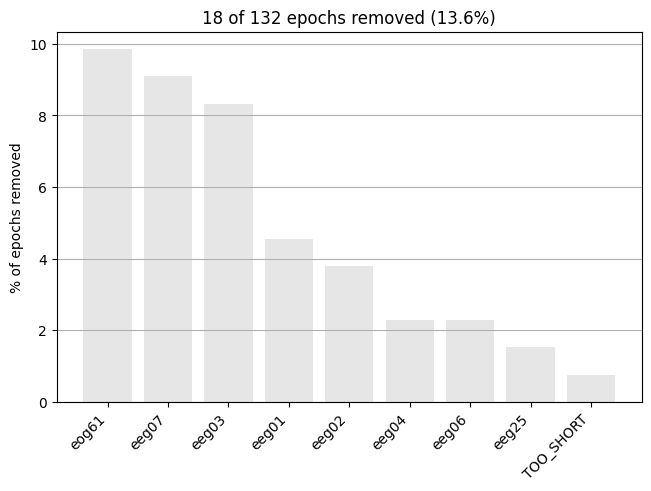

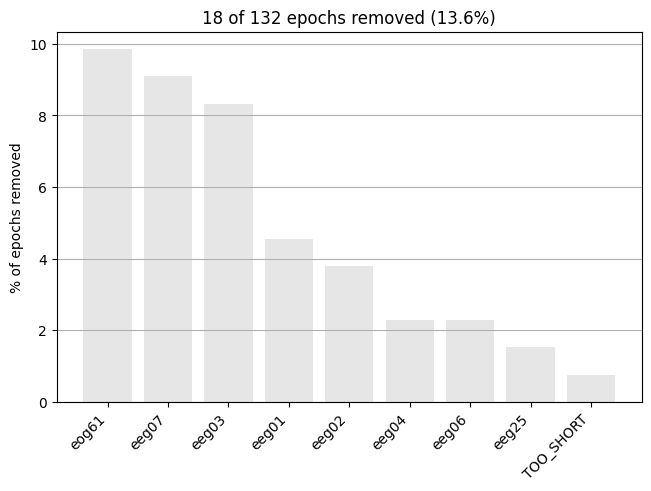

In [11]:
epochs.plot_drop_log()

Epochs can also be dropped automatically if the event around which the epoch
is created is too close to the start or end of the :class:`~mne.io.Raw`
object (e.g., if the epoch would extend past the end of the recording; this
is the cause for the "TOO_SHORT" entry in the
:meth:`~mne.Epochs.plot_drop_log` plot).

Epochs may also be dropped automatically if the :class:`~mne.io.Raw` object
contains :term:`annotations` that begin with either ``bad`` or ``edge``
("edge" annotations are automatically inserted when concatenating two or more
:class:`~mne.io.Raw` objects). See `tut-reject-data-spans` for more
information on annotation-based epoch rejection.

Now that we've dropped all bad epochs, let's look at our evoked responses for
some conditions we care about. Here, the :meth:`~mne.Epochs.average` method
will create an :class:`~mne.Evoked` object, which we can then plot. Notice
that we select which condition we want to average using square-bracket
indexing (like for a :class:`dictionary <dict>`). This returns a subset with
only the desired epochs, which we then average:



In [12]:
l_aud = epochs["auditory/left"].average()
l_vis = epochs["visual/left"].average()

These :class:`~mne.Evoked` objects have their own interactive plotting method
(though again, it won't be interactive on the documentation website).
Clicking and dragging a span of time will generate a topography of scalp
potentials for the selected time segment. Here, we also demonstrate built-in
color-coding the channel traces by location:



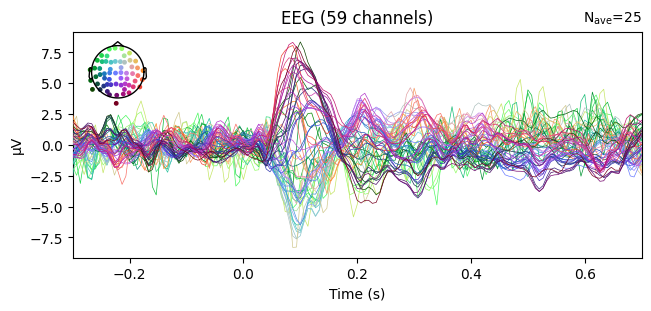

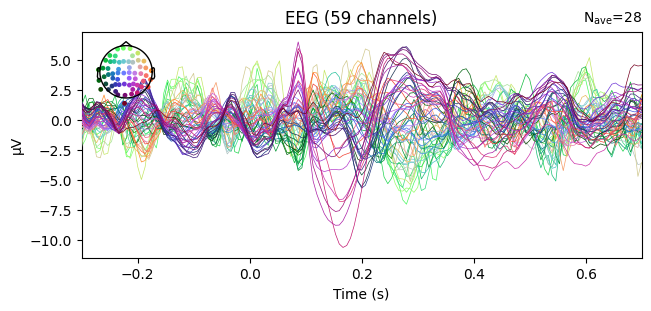

In [13]:
fig1 = l_aud.plot()
fig2 = l_vis.plot(spatial_colors=True)

Scalp topographies can also be obtained non-interactively with the
:meth:`~mne.Evoked.plot_topomap` method. Here, we display topomaps of the
average evoked potential in 50 ms time windows centered at -200 ms, 100 ms,
and 400 ms.



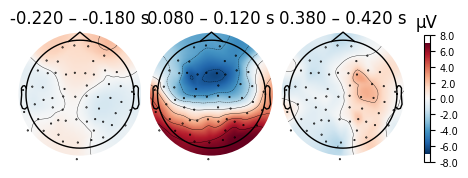

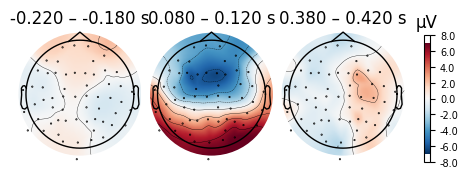

In [14]:
l_aud.plot_topomap(times=[-0.2, 0.1, 0.4], average=0.05)

Considerable customization of these plots is possible, see the docstring of
:meth:`~mne.Evoked.plot_topomap` for details.

There is also a built-in method for combining butterfly plots of the signals
with scalp topographies called :meth:`~mne.Evoked.plot_joint`. Like in
:meth:`~mne.Evoked.plot_topomap`, you can specify times for the scalp
topographies or you can let the method choose times automatically as shown
here:



Projections have already been applied. Setting proj attribute to True.


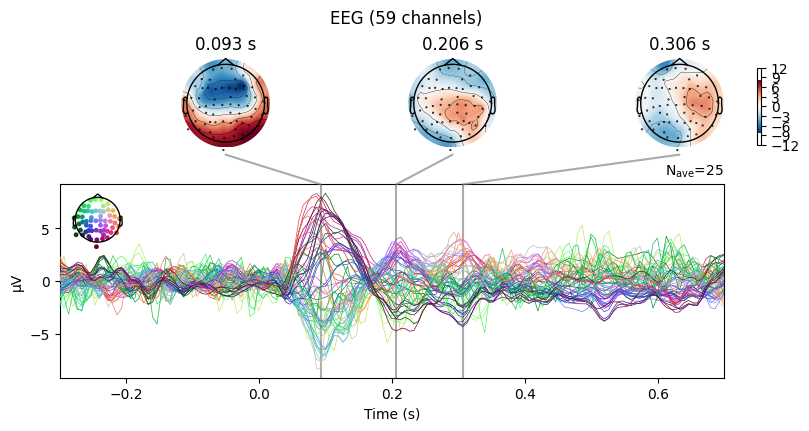

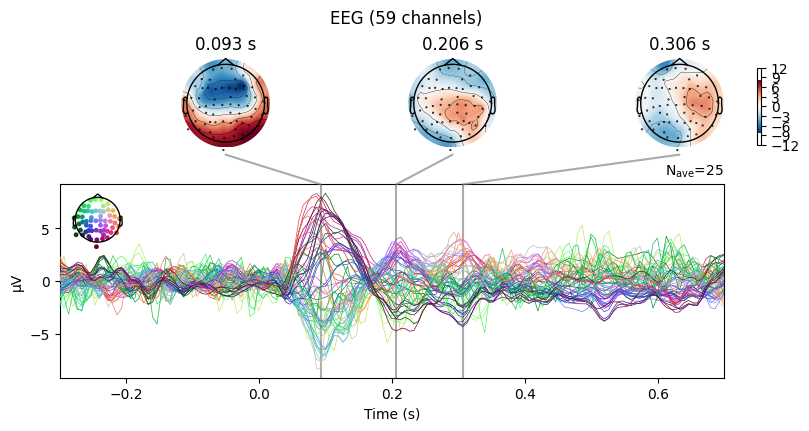

In [15]:
l_aud.plot_joint()

## Global field power (GFP)

Global field power :footcite:`Lehmann1980,Lehmann1984,Murray2008` is,
generally speaking, a measure of agreement of the signals picked up by all
sensors across the entire scalp: if all sensors have the same value at a
given time point, the GFP will be zero at that time point. If the signals
differ, the GFP will be non-zero at that time point. GFP
peaks may reflect "interesting" brain activity, warranting further
investigation. Mathematically, the GFP is the population standard
deviation across all sensors, calculated separately for every time point.

You can plot the GFP using `evoked.plot(gfp=True) <mne.Evoked.plot>`. The GFP
trace will be black if ``spatial_colors=True`` and green otherwise. The EEG
reference does not affect the GFP:



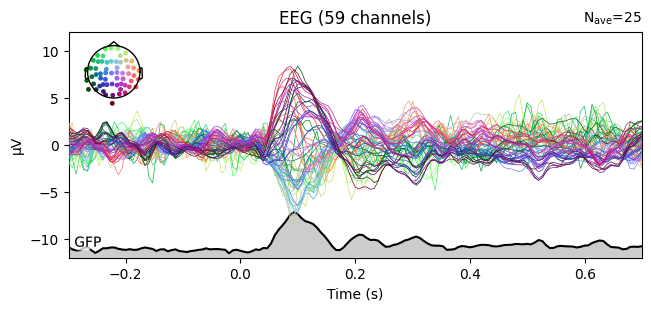

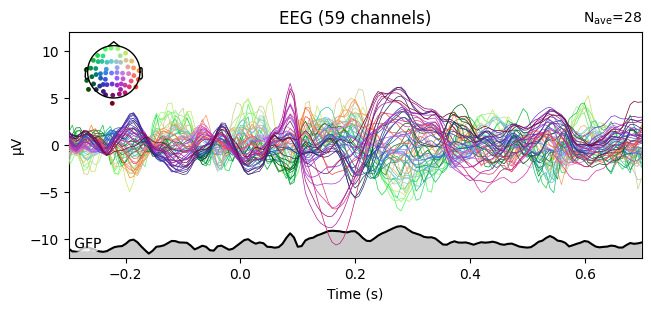

In [16]:
for evk in (l_aud, l_vis):
    evk.plot(gfp=True, spatial_colors=True, ylim=dict(eeg=[-12, 12]))

To plot the GFP by itself, you can pass ``gfp='only'`` (this makes it easier
to read off the GFP data values, because the scale is aligned):



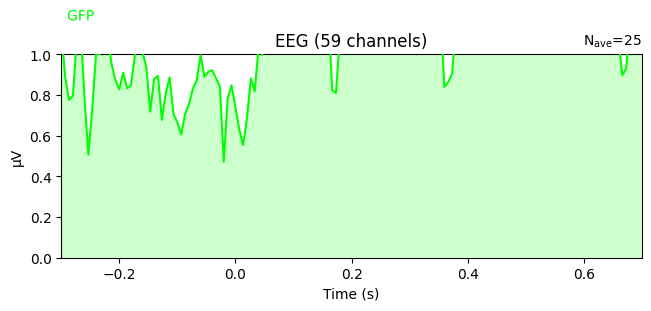

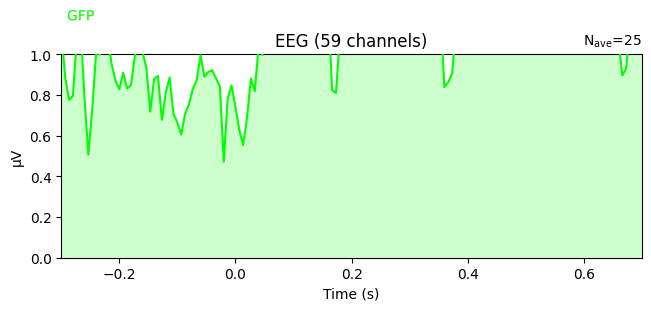

In [17]:
l_aud.plot(gfp="only")

The GFP is the population standard deviation of the signal
across channels. To compute it manually, we can leverage the fact that
`evoked.data <mne.Evoked.data>` is a :class:`NumPy array <numpy.ndarray>`,
and verify by plotting it using plain Matplotlib commands:



[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'GFP (µV)'), Text(0.5, 1.0, 'EEG')]

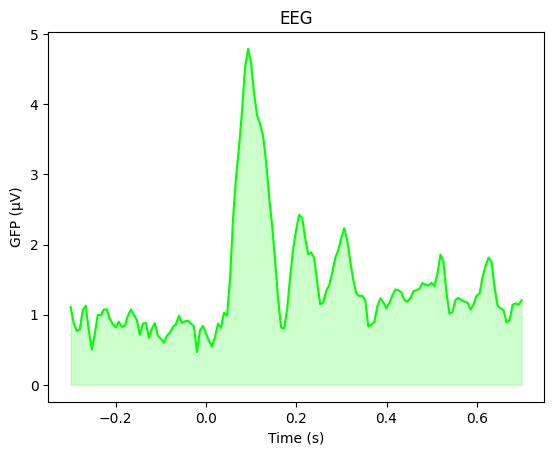

In [18]:
gfp = l_aud.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(l_aud.times, gfp * 1e6, color="lime")
ax.fill_between(l_aud.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)", title="EEG")

## Averaging across channels with regions of interest

Since our sample data contains responses to left and right auditory and
visual stimuli, we may want to compare left versus right regions of interest
(ROIs). To average across channels in a given ROI, we first find the relevant
channel indices. Revisiting the 2D sensor plot above, we might choose the
following channels for left and right ROIs, respectively:



In [19]:
left = ["eeg17", "eeg18", "eeg25", "eeg26"]
right = ["eeg23", "eeg24", "eeg34", "eeg35"]

left_ix = mne.pick_channels(l_aud.info["ch_names"], include=left)
right_ix = mne.pick_channels(l_aud.info["ch_names"], include=right)

Now we can create a new Evoked object with two virtual channels (one for each
ROI):



Applying baseline correction (mode: mean)
['left_ROI', 'right_ROI']


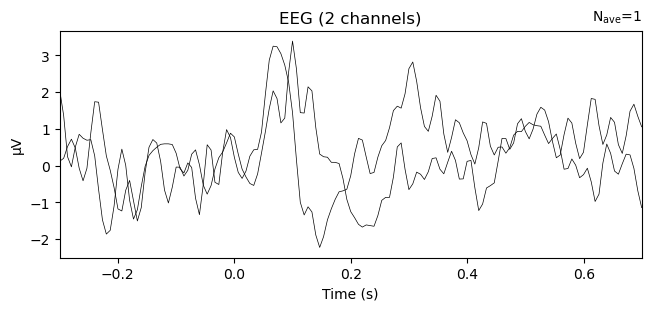

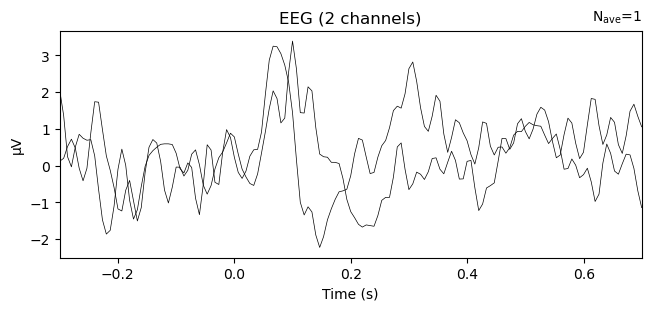

In [20]:
roi_dict = dict(left_ROI=left_ix, right_ROI=right_ix)
roi_evoked = mne.channels.combine_channels(l_aud, roi_dict, method="mean")
print(roi_evoked.info["ch_names"])
roi_evoked.plot()

## Comparing conditions

If we wanted to contrast auditory to visual stimuli, a useful function is
:func:`mne.viz.plot_compare_evokeds`. By default, this function will combine
all channels in each evoked object using GFP (or RMS for MEG channels); here
instead we specify to combine by averaging, and restrict it to a subset of
channels by passing ``picks``:



combining channels using "mean"
combining channels using "mean"


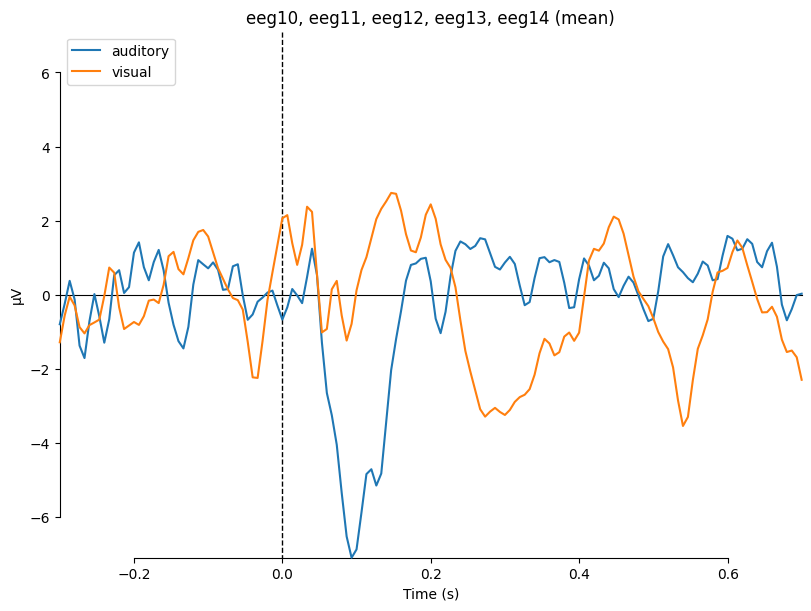

[<Figure size 800x600 with 1 Axes>]

In [20]:
evokeds = dict(auditory=l_aud, visual=l_vis)
picks = [f"eeg{n}" for n in range(10, 15)]
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine="mean")

We can also generate confidence intervals by treating each epoch as a
separate observation using :meth:`~mne.Epochs.iter_evoked`. A confidence
interval across subjects could also be obtained by passing a list of
:class:`~mne.Evoked` objects (one per subject) to the
:func:`~mne.viz.plot_compare_evokeds` function.



combining channels using "mean"
combining channels using "mean"


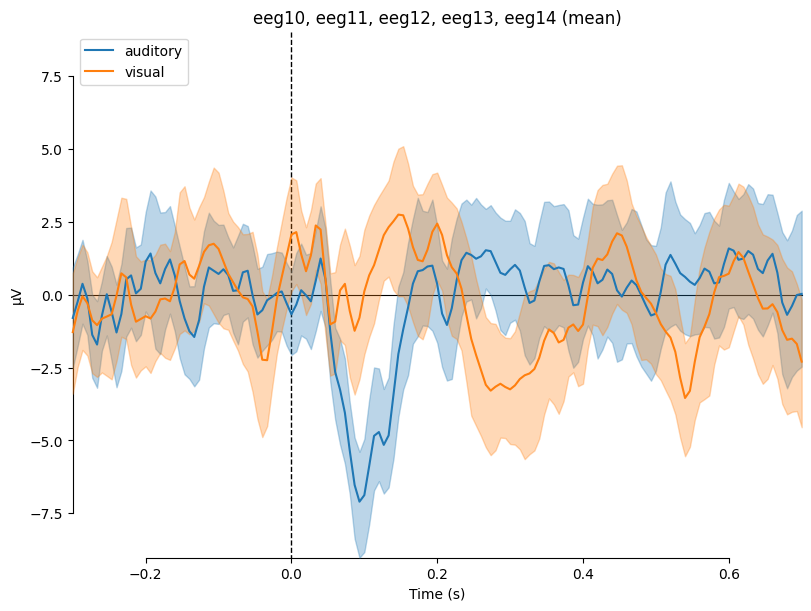

[<Figure size 800x600 with 1 Axes>]

In [21]:
evokeds = dict(
    auditory=list(epochs["auditory/left"].iter_evoked()),
    visual=list(epochs["visual/left"].iter_evoked()),
)
mne.viz.plot_compare_evokeds(evokeds, combine="mean", picks=picks)

We can also compare conditions by subtracting one :class:`~mne.Evoked` object
from another using the :func:`mne.combine_evoked` function (this function
also supports pooling of epochs without subtraction).



Projections have already been applied. Setting proj attribute to True.


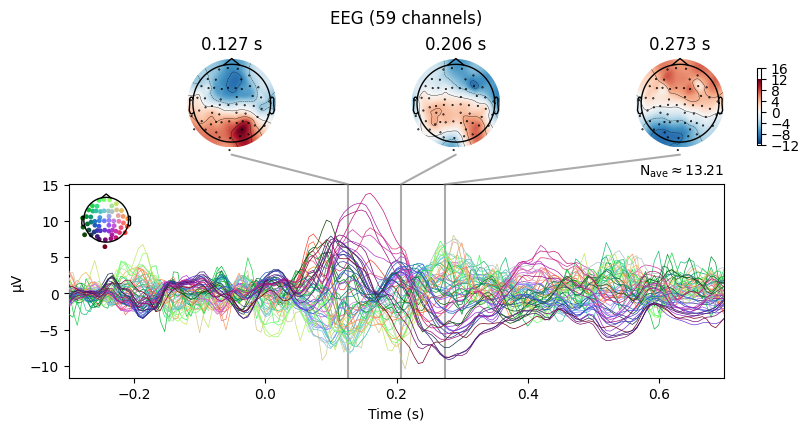

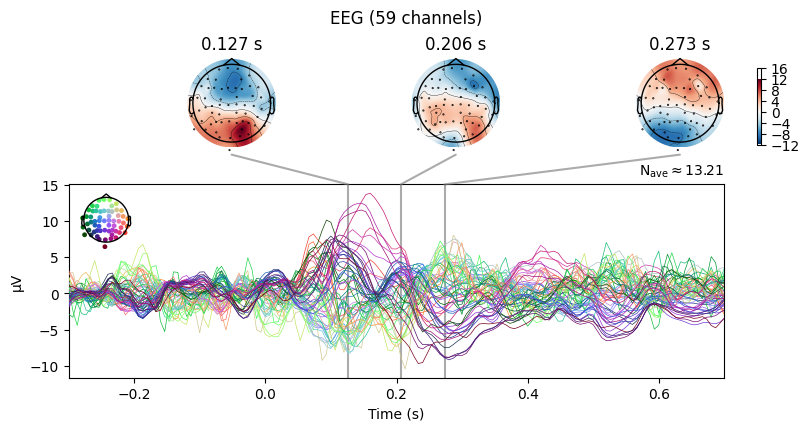

In [22]:
aud_minus_vis = mne.combine_evoked([l_aud, l_vis], weights=[1, -1])
aud_minus_vis.plot_joint()

In [23]:
grand_average = mne.grand_average([l_aud, l_vis])
print(grand_average)

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Identifying common channels ...
<Evoked | 'Grand average (n = 2)' (average, N=2), -0.29969 – 0.69928 s, baseline -0.299693 – 0 s, 60 ch, ~3.0 MiB>


For combining *conditions* it is also possible to make use of :term:`HED`
tags in the condition names when selecting which epochs to average. For
example, we have the condition names:



In [24]:
list(event_dict)

['auditory/left',
 'auditory/right',
 'visual/left',
 'visual/right',
 'face',
 'buttonpress']

We can select the auditory conditions (left and right together) by passing:



In [25]:
epochs["auditory"].average()

<Evoked | '0.48 × auditory/left + 0.52 × auditory/right' (average, N=52), -0.29969 – 0.69928 s, baseline -0.299693 – 0 s, 60 ch, ~3.0 MiB>

See `tut-section-subselect-epochs` for more details on that.

The tutorials `tut-epochs-class` and `tut-evoked-class` have many
more details about working with the :class:`~mne.Epochs` and
:class:`~mne.Evoked` classes.



## Amplitude and latency measures
It is common in ERP research to extract measures of amplitude or latency to
compare across different conditions. There are many measures that can be
extracted from ERPs, and many of these are detailed (including the respective
strengths and weaknesses) in chapter 9 of Luck :footcite:`Luck2014` (also see
the [Measurement Tool](https://bit.ly/37uydRw) in the ERPLAB Toolbox
:footcite:`Lopez-CalderonLuck2014`).

This part of the tutorial will demonstrate how to extract three common
measures:

* Peak latency
* Peak amplitude
* Mean amplitude

### Peak latency and amplitude

The most common measures of amplitude and latency are peak measures.
Peak measures are basically the maximum amplitude of the signal in a
specified time window and the time point (or latency) at which the peak
amplitude occurred.

Peak measures can be obtained using the :meth:`~mne.Evoked.get_peak` method.
There are two important things to point out about
:meth:`~mne.Evoked.get_peak`. First, it finds the strongest peak
looking across **all channels** of the selected type that are available in
the :class:`~mne.Evoked` object. As a consequence, if you want to restrict
the search to a group of channels or a single channel, you
should first use the :meth:`~mne.Evoked.pick` or
:meth:`~mne.Evoked.pick_channels` methods. Second, the
:meth:`~mne.Evoked.get_peak` method can find different types of peaks using
the ``mode`` argument. There are three options:

* ``mode='pos'``: finds the peak with a positive voltage (ignores
  negative voltages)
* ``mode='neg'``: finds the peak with a negative voltage (ignores
  positive voltages)
* ``mode='abs'``: finds the peak with the largest absolute voltage
  regardless of sign (positive or negative)

The following example demonstrates how to find the first positive peak in the
ERP (i.e., the P100) for the left visual condition (i.e., the
``l_vis`` :class:`~mne.Evoked` object). The time window used to search for
the peak ranges from 0.08 to 0.12 s. This time window was selected because it
is when P100 typically occurs. Note that all ``'eeg'`` channels are submitted
to the :meth:`~mne.Evoked.get_peak` method.



In [26]:
# Define a function to print out the channel (ch) containing the
# peak latency (lat; in msec) and amplitude (amp, in µV), with the
# time range (tmin and tmax) that was searched.
# This function will be used throughout the remainder of the tutorial.
def print_peak_measures(ch, tmin, tmax, lat, amp):
    print(f"Channel: {ch}")
    print(f"Time Window: {tmin * 1e3:.3f} - {tmax * 1e3:.3f} ms")
    print(f"Peak Latency: {lat * 1e3:.3f} ms")
    print(f"Peak Amplitude: {amp * 1e6:.3f} µV")


# Get peak amplitude and latency from a good time window that contains the peak
good_tmin, good_tmax = 0.08, 0.12
ch, lat, amp = l_vis.get_peak(
    ch_type="eeg", tmin=good_tmin, tmax=good_tmax, mode="pos", return_amplitude=True
)

# Print output from the good time window that contains the peak
print("** PEAK MEASURES FROM A GOOD TIME WINDOW **")
print_peak_measures(ch, good_tmin, good_tmax, lat, amp)

** PEAK MEASURES FROM A GOOD TIME WINDOW **
Channel: eeg55
Time Window: 80.000 - 120.000 ms
Peak Latency: 86.578 ms
Peak Amplitude: 6.508 µV


The output shows that channel ``eeg55`` had the maximum positive peak in
the chosen time window from all of the ``'eeg'`` channels searched.
In practice, one might want to pull out the peak for
an *a priori* region of interest or a single channel depending on the study.
This can be done by combining the :meth:`~mne.Evoked.pick`
or :meth:`~mne.Evoked.pick_channels` methods with the
:meth:`~mne.Evoked.get_peak` method.

Here, let's assume we believe the effects of interest will occur
at ``eeg59``.



In [27]:
# Fist, return a copy of l_vis to select the channel from
l_vis_roi = l_vis.copy().pick("eeg59")

# Get the peak and latency measure from the selected channel
ch_roi, lat_roi, amp_roi = l_vis_roi.get_peak(
    tmin=good_tmin, tmax=good_tmax, mode="pos", return_amplitude=True
)

# Print output
print("** PEAK MEASURES FOR ONE CHANNEL FROM A GOOD TIME WINDOW **")
print_peak_measures(ch_roi, good_tmin, good_tmax, lat_roi, amp_roi)

** PEAK MEASURES FOR ONE CHANNEL FROM A GOOD TIME WINDOW **
Channel: eeg59
Time Window: 80.000 - 120.000 ms
Peak Latency: 86.578 ms
Peak Amplitude: 5.713 µV


While the peak latencies are the same in channels ``eeg55`` and ``eeg59``,
the peak amplitudes differ. This approach can also be applied to virtual
channels created with the :func:`~mne.channels.combine_channels` function and
difference waves created with the :func:`mne.combine_evoked` function (see
``aud_minus_vis`` in section `Comparing conditions`_ above).

Peak measures are very susceptible to high frequency noise in the
signal (for discussion, see :footcite:`Luck2014`). Specifically, high
frequency noise positively biases peak amplitude measures. This bias can
confound comparisons across conditions where ERPs differ in the level of high
frequency noise, such as when the conditions differ in the number of trials
contributing to the ERP. One way to avoid this is to apply a non-causal
low-pass filter to the ERP. Low-pass filters reduce the contribution of high
frequency noise by smoothing out fast (i.e., high frequency) fluctuations in
the signal (see `disc-filtering`). While this can reduce the positive
bias in peak amplitude measures caused by high frequency noise, low-pass
filtering the ERP can introduce challenges in interpreting peak latency
measures for effects of interest :footcite:`Rousselet2012,VanRullen2011`.

If using peak measures, it is critical to visually inspect the data to
make sure the selected time window actually contains a peak. The
meth:`~mne.Evoked.get_peak` method detects the maximum or minimum voltage in
the specified time range and returns the latency and amplitude of this peak.
There is no guarantee that this method will return an actual peak. Instead,
it may return a value on the rising or falling edge of a peak we are trying
to find.

The following example demonstrates why visual inspection is crucial. Below,
we use a known bad time window (0.095 to 0.135 s) to search for a peak in
channel ``eeg59``.



In [28]:
# Get BAD peak measures
bad_tmin, bad_tmax = 0.095, 0.135
ch_roi, bad_lat_roi, bad_amp_roi = l_vis_roi.get_peak(
    mode="pos", tmin=bad_tmin, tmax=bad_tmax, return_amplitude=True
)

# Print output
print("** PEAK MEASURES FOR ONE CHANNEL FROM A BAD TIME WINDOW **")
print_peak_measures(ch_roi, bad_tmin, bad_tmax, bad_lat_roi, bad_amp_roi)

** PEAK MEASURES FOR ONE CHANNEL FROM A BAD TIME WINDOW **
Channel: eeg59
Time Window: 95.000 - 135.000 ms
Peak Latency: 99.898 ms
Peak Amplitude: 1.487 µV


If all we had were the above values, it would be unclear if they are truly
identifying a peak in the ERP. In fact, the 0.095 to 0.135 s time window
actually does not contain the true peak, which is shown in the top panel
below. The bad time window (highlighted in orange) does not contain the true
peak (the pink star). In contrast, the time window defined initially (0.08 to
0.12 s; highlighted in blue) returns an actual peak instead of a just a
maximum or minimum in the searched time window. Visual inspection will always
help you to convince yourself that the returned values are actual peaks.



Need more than one channel to make topography for eeg. Disabling interactivity.
Need more than one channel to make topography for eeg. Disabling interactivity.


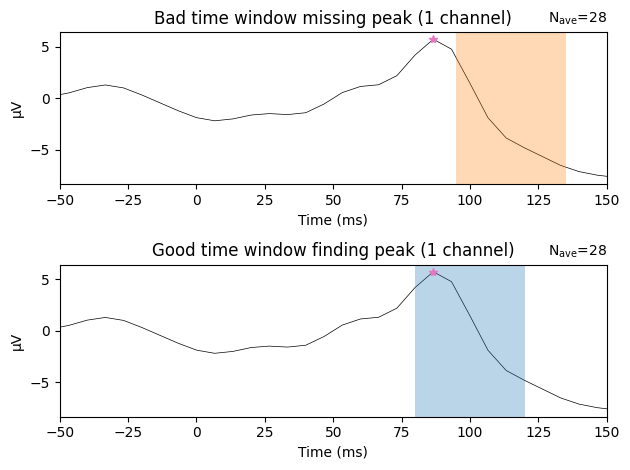

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=1, layout="tight")
words = (("Bad", "missing"), ("Good", "finding"))
times = (np.array([bad_tmin, bad_tmax]), np.array([good_tmin, good_tmax]))
colors = ("C1", "C0")

for ix, ax in enumerate(axs):
    title = "{} time window {} peak".format(*words[ix])
    l_vis_roi.plot(axes=ax, time_unit="ms", show=False, titles=title)
    ax.plot(lat_roi * 1e3, amp_roi * 1e6, marker="*", color="C6")
    ax.axvspan(*(times[ix] * 1e3), facecolor=colors[ix], alpha=0.3)
    ax.set_xlim(-50, 150)  # Show zoomed in around peak

### Mean Amplitude

Another common practice in ERP studies is to define a component (or effect)
as the mean amplitude within a specified time window. One advantage of this
approach is that it is less sensitive to high frequency noise (compared to
peak amplitude measures), because averaging over a time window acts as a
low-pass filter (see discussion in the previous section
`Peak latency and amplitude`_).

When using mean amplitude measures, selecting the time window based on
the effect of interest (e.g., the difference between two conditions) can
inflate the likelihood of finding false positives in your
results :footcite:`LuckGaspelin2017`. There are other, and
better, ways to identify a time window to use for extracting mean amplitude
measures. First, you can use an *a priori* time window based on prior
research.
A second option is to define a time window from an independent condition or
set of trials not used in the analysis (e.g., a "localizer"). A third
approach is
to define a time window using the across-condition grand average. This latter
approach is not circular because the across-condition mean and condition
difference are independent of one another. The issues discussed above also
apply to selecting channels used for analysis.

The following example demonstrates how to pull out the mean amplitude
from the left visual condition (i.e., the ``l_vis`` :class:`~mne.Evoked`
object) from selected channels and time windows. Stimulating the
left visual field increases neural activity of visual cortex in the
contralateral (i.e., right) hemisphere. We can test this by examining the
amplitude of the ERP for left visual field stimulation over right
(contralateral) and left (ipsilateral) channels. The channels used for this
analysis are ``eeg54`` and ``eeg57`` (left hemisphere), and ``eeg59`` and
``eeg55`` (right hemisphere). The time window used is 0.08 (``good_tmin``)
to 0.12 s (``good_tmax``) as it corresponds to when the P100 typically
occurs.
The P100 is sensitive to left and right visual field stimulation. The mean
amplitude is extracted from the above four channels and stored in a
:class:`pandas.DataFrame`.



In [30]:
# Select all of the channels and crop to the time window
channels = ["eeg54", "eeg57", "eeg55", "eeg59"]
hemisphere = ["left", "left", "right", "right"]
l_vis_mean_roi = l_vis.copy().pick(channels).crop(tmin=good_tmin, tmax=good_tmax)

# Extract mean amplitude in µV over time
mean_amp_roi = l_vis_mean_roi.data.mean(axis=1) * 1e6

# Store the data in a data frame
mean_amp_roi_df = pd.DataFrame(
    {
        "ch_name": l_vis_mean_roi.ch_names,
        "hemisphere": ["left", "left", "right", "right"],
        "mean_amp": mean_amp_roi,
    }
)

# Print the data frame
print(mean_amp_roi_df.groupby("hemisphere").mean(numeric_only=True))

            mean_amp
hemisphere          
left       -0.279764
right       0.685840


As demonstrated in this example, the mean amplitude was higher and
positive in right compared to left hemisphere channels. It should be
reiterated that both spatial and temporal windows used in the analysis should
be determined in an independent manner (e.g., defined *a priori* from prior
research, a "localizer" or another independent condition) and not based
on the data you will use to test your hypotheses.

The example can be modified to extract the mean amplitude
from all channels and store the resulting output in a
:class:`pandas.DataFrame`. This can be useful for statistical analyses
conducted in other programming languages.



In [31]:
# Extract mean amplitude for all channels in l_vis (including `eog`)
l_vis_cropped = l_vis.copy().crop(tmin=good_tmin, tmax=good_tmax)
mean_amp_all = l_vis_cropped.data.mean(axis=1) * 1e6
mean_amp_all_df = pd.DataFrame(
    {"ch_name": l_vis_cropped.info["ch_names"], "mean_amp": mean_amp_all}
)
mean_amp_all_df["tmin"] = good_tmin
mean_amp_all_df["tmax"] = good_tmax
mean_amp_all_df["condition"] = "Left/Visual"
with pd.option_context("display.max_columns", None):
    print(mean_amp_all_df.head())
    print(mean_amp_all_df.tail())

  ch_name  mean_amp  tmin  tmax    condition
0   eeg01 -1.689513  0.08  0.12  Left/Visual
1   eeg02 -0.078492  0.08  0.12  Left/Visual
2   eeg03 -0.381191  0.08  0.12  Left/Visual
3   eeg04 -1.609264  0.08  0.12  Left/Visual
4   eeg05 -1.113717  0.08  0.12  Left/Visual
   ch_name  mean_amp  tmin  tmax    condition
55   eeg56  2.064174  0.08  0.12  Left/Visual
56   eeg57 -0.259681  0.08  0.12  Left/Visual
57   eeg58  0.156472  0.08  0.12  Left/Visual
58   eeg59  0.802306  0.08  0.12  Left/Visual
59   eeg60  0.878811  0.08  0.12  Left/Visual




### References
.. footbibliography::

